In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DEVICE

device(type='cuda')

1. Модель Исполнитель

In [4]:
class ActorNet(nn.Module):
    # слои модели   
    def __init__(self, n_state, n_action, n_hidden):
        super().__init__()

        self.hidden = nn.Linear(n_state, n_hidden)
        self.output = nn.Linear(n_hidden, n_action)

    # способ обучения модели
    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

2. Модель Критик

In [5]:
class CriticNet(nn.Module):
    # слои модели
    def __init__(self, n_state, n_hidden):
        super().__init__()

        self.hidden = nn.Linear(n_state, n_hidden)
        self.output = nn.Linear(n_hidden, 1)

    # способ обучения модели
    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

3. Функция политики выбора действия

In [6]:
# Получить у модели Исполнителя действие максимальной вероятности без обучния
def policy(agent, state):
    with torch.no_grad():
        state = torch.tensor(state, device=DEVICE)
        actions = agent(state)
        probs = F.softmax(actions, dim=-1)
        a = torch.multinomial(probs, num_samples=1)
        return a.tolist()[0]
        #a = torch.argmax(actions)
        #return a.item()

4. Функция обучения модели

In [7]:
def a2c_learning(env, agent_actor, agent_critic, opt_actor, opt_critic, sch_actor, sch_critic, n_episodes, total_reward_episode, gamma=0.9):



    # для каждой эпохи
    for n in tqdm(range(n_episodes)):

        # сбросить среду
        state,_ = env.reset()
        # создать создать списки стартового состояния, действий и наград за действия для каждого шага
        states = []
        actions = []
        rewards = []

        is_step = True
        # запуск среды
        while is_step:
            # получить действие от Испольнителя (без обученния)
            action = policy(agent_actor, state)
            # запустить среду с этим действием и получить ее результирующее состояние
            next_state, reward, is_done, is_break, _ = env.step(action)
            # сохранить в списки стартового состояния, действие и награду за действие
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            is_step = not is_done and not is_break

        states = torch.tensor(states, dtype=torch.float, requires_grad=True, device=DEVICE)
        actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE)

        # из списка наград за отдельное действие получить список сумм нагдад за все действия до текущего в списке
        # список Полных наград для кажного состояния среды
        cum_rewards = []
        Gt = 0
        for reward in rewards[::-1]:
            Gt += gamma * reward
            cum_rewards.append(Gt)
        cum_rewards = torch.tensor(cum_rewards[::-1], dtype=torch.float, requires_grad=True, device=DEVICE)

        # Обучение модели Критика
        # обучить модель на списке стартового состояния
        values = agent_critic(states)
        values = values.squeeze(dim=1)
        # обнулить градиенты
        opt_critic.zero_grad()
        # считаем лосс из оценок Критика () и списка полных вознаграждений
        vf_loss = F.mse_loss(values, cum_rewards, reduction="none")
        # считаем сумму потерь
        loss = vf_loss.sum()
        # делаем шаг лосс в обратном направлении
        loss.backward()
        # делаем шаг оптимизатора
        opt_critic.step()

        # получение ценности состояний из оценок Критика и списка полных вознаграждений (без обучения)
        with torch.no_grad():
            values = agent_critic(states)
            values = values.squeeze(dim=1)
        advantages = cum_rewards - values

        # Обучение модели Исполнителя
        # обучить модель на списке стартового состояния
        q_values = agent_actor(states)
        # обнулить градиенты
        opt_actor.zero_grad()
        # считаем лосс из оценок Исполнителя (действия) и списка осуществленных действий (логарифм вероятностей изменения состояний)
        log_probs = -F.cross_entropy(q_values, actions, reduction="none")
        # считаем сумму произведений отрицательных логорифмов потери на ценность состояний
        pi_loss = -log_probs * advantages
        act_loss = pi_loss.sum()
        # делаем шаг лосс в обратном направлении
        act_loss.backward()
        # делаем шаг оптимизатора
        opt_actor.step()

        total_reward_episode[n] = sum(rewards)

        if total_reward_episode[n] > 0:
            sch_actor.step()
            sch_critic.step()


5. Среда обучения 

In [8]:
env = gym.make('LunarLander-v2')

6. Создание моделей с заданными параметрами

In [9]:
# параемры моделей
# количество входящих парамеров
n_state = env.observation_space.shape[0]
# количество выходящих парамеров исполинтельной сети
n_action = env.action_space.n
# количество скрытых нейронов
n_hidden = 128
# скорость обучения
LR = 0.001


# 1. Задать модель - nn.Module
agent_actor = ActorNet(n_state, n_action, n_hidden).to(DEVICE)
agent_critic = CriticNet(n_state, n_action).to(DEVICE)

# 2. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
opt_actor = torch.optim.Adam(agent_actor.parameters(), lr=LR)
opt_critic = torch.optim.Adam(agent_critic.parameters(), lr=LR)

# 3. Задать функцию скорости обучения - torch.optim.lr_scheduler
sch_actor = torch.optim.lr_scheduler.StepLR(opt_actor, step_size=10, gamma=0.9)
sch_critic = torch.optim.lr_scheduler.StepLR(opt_actor, step_size=10, gamma=0.9)

7. Запуск обучения

In [10]:
# общее количество эпох
n_episodes = 1500
# коэффициент обесценивания 
gamma = 0.99
# общая награда в каждом эпизоде
total_reward_episode = np.zeros(n_episodes)

# запуск функции обучения
a2c_learning(env, agent_actor, agent_critic, opt_actor, opt_critic, sch_actor, sch_critic, n_episodes, total_reward_episode, gamma)

  0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\v.tyumenev\AppData\Local\Temp\ipykernel_832\2443328358.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float, requires_grad=True, device=DEVICE)
100%|██████████| 1500/1500 [01:33<00:00, 16.03it/s]


8. Результаты

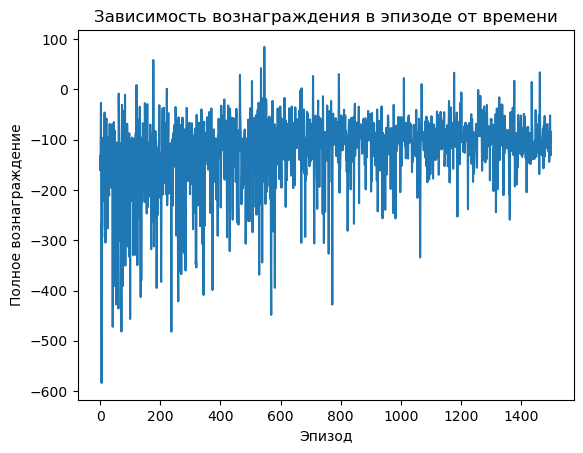

In [11]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()